# Analisis de Reservas de un hotel

* #####  En esta ocasion se analisará y se destacará patrones de reservas que son canceladas. De esta forma ayudar a la empresa a tomar decisiones para mejorar en el area

### <P style="color:rgb(150,30,95);font-size:30px"> <b> HIPOTESIS </b></P>
- Tarifas elevadas
- Epoca del año
- Puede haber una tendencia relacionada con el pais
- Método de compra. Ya sea online o presencial

### Importamos las librerias a utilizar

In [1]:
import pandas as pd #Analisis de datos
import matplotlib.pyplot as plt #Creacion de dashboards
import seaborn as sns #Creacion de dashboards
import warnings #Ignorar advertencias 
from bs4 import BeautifulSoup # Web-Scrapping
import requests 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

* El dataset utilizado se encuentra en el siguiente enlance: <a href="https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand">Booking Dataset</a>

In [2]:
# Lectura del dataset
booking = pd.read_csv('hotel_bookings.csv')
booking.shape

(119390, 32)

In [3]:
# Realizamos una copia para no afectar el dataset origibal

booking_copy = booking.copy()

In [4]:
# Visualizacion de los primeros datos
booking_copy.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015


### <p style="color:rgb(100,200,200)"> <b>Primeros pasos</b></p>

1) Eliminacion de columnas en caso de poseer gran cantidad de nulos.

2) Chequeo del tipo de dato.

3) Cambio de valores para que sean más explicitos en caso de ser necesario.

4) Scrapping para conocer a que pais hace referencia la columna `country`.

1. <p style="color:rgb(180,100,180)"><i> Chequeo de nulos. </i> </p>

In [5]:
booking_copy.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

- Como se puede observar la columna `company` posee gran cantidad de nulos con respecto la cantidad total de registros del <i>Dataset</d>. Por estos motivos, será eliminada

In [6]:
booking_copy.drop(columns="company", inplace=True)

2. <p style="color:rgb(180,100,180)"><i> Chequeo del tipo de dato. </i> </p>

In [7]:
booking_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
# Columna reservation_status_date sera cambiada a tipo fecha.

booking_copy["reservation_status_date"] = pd.to_datetime(booking_copy["reservation_status_date"], format="%d/%m/%Y")


3. <p style="color:rgb(180,100,180)"> En esta ocasion cambiaremos los valores de la columna `meal` para que sean más especificos y faciles de entender</p>

<b>Los valores son:</b>

- Undefined/SC (Self-Catering):  No tiene o no esta definido
- BB: (Bed & Breakfast) Incluye desayuno
- HB: (Half Board) Desayuno y una comida más
- FB: (Full Board) Desayuno, Almuerzo y Cena

In [9]:
booking_copy.meal.unique(), booking_copy.meal.value_counts(normalize=True)

(array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object),
 meal
 BB           0.773180
 HB           0.121141
 SC           0.089203
 Undefined    0.009791
 FB           0.006684
 Name: proportion, dtype: float64)

* Como los valores *undefined* no representan gran porcentaje de los datos(solo el 0.9%), se los agrupara con ***self-catering***

In [10]:
# Diccionario para reemplazar valores

meals = {
    "BB": "Bread & Breakfast",
    "HB": "Haf-Board",
    "FB": "Full-Board",
    "SC": "Self-Catering",
    "Undefined":"Self-Catering"
}

booking_copy["meal"].replace(meals,inplace=True)

booking_copy.meal.unique()

array(['Bread & Breakfast', 'Full-Board', 'Haf-Board', 'Self-Catering'],
      dtype=object)

3. <p style="color:rgb(180,100,180)">Web Scrapping para traer los nombres completos de los paises</p>

In [11]:
def get_countries():
    countries_page = requests.get('https://www.iban.com/country-codes').text #Pagina que lista los paises junto a su código

    countries_soup = BeautifulSoup(countries_page, "html.parser")

    countries_table = countries_soup.find('tbody') #Buscamos el elemento que contiene los paises

    countries_rows = countries_table.find_all("tr") # Buscamos las filas a iterar

    countries = {}

    for country in countries_rows:

        country_list = country.get_text().strip().split("\n")
        countries[country_list[2]] = country_list[0]

    return countries

countries = get_countries()

In [12]:
# Definimos el diccionario

countries = get_countries()

booking_copy["country"].replace(countries, inplace=True)

In [13]:
booking_copy.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,Bread & Breakfast,Portugal,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,Bread & Breakfast,Portugal,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


#### <u> Tratamiento de outliers </u>

In [14]:
booking_copy.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,2.321149,101.831122,0.062518,0.571363,2016-07-30 00:24:47.883407104
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,69.290000,0.000000,0.000000,2016-02-01 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,94.575000,0.000000,0.000000,2016-08-07 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,0.000000,126.000000,0.000000,1.000000,2017-02-08 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,17.594721,50.535790,0.245291,0.792798,NaN


- Realizaremos un ***boxplot*** en las columnas `adults`, `adr` (Average Day Rate), `children`,`babies`. Si

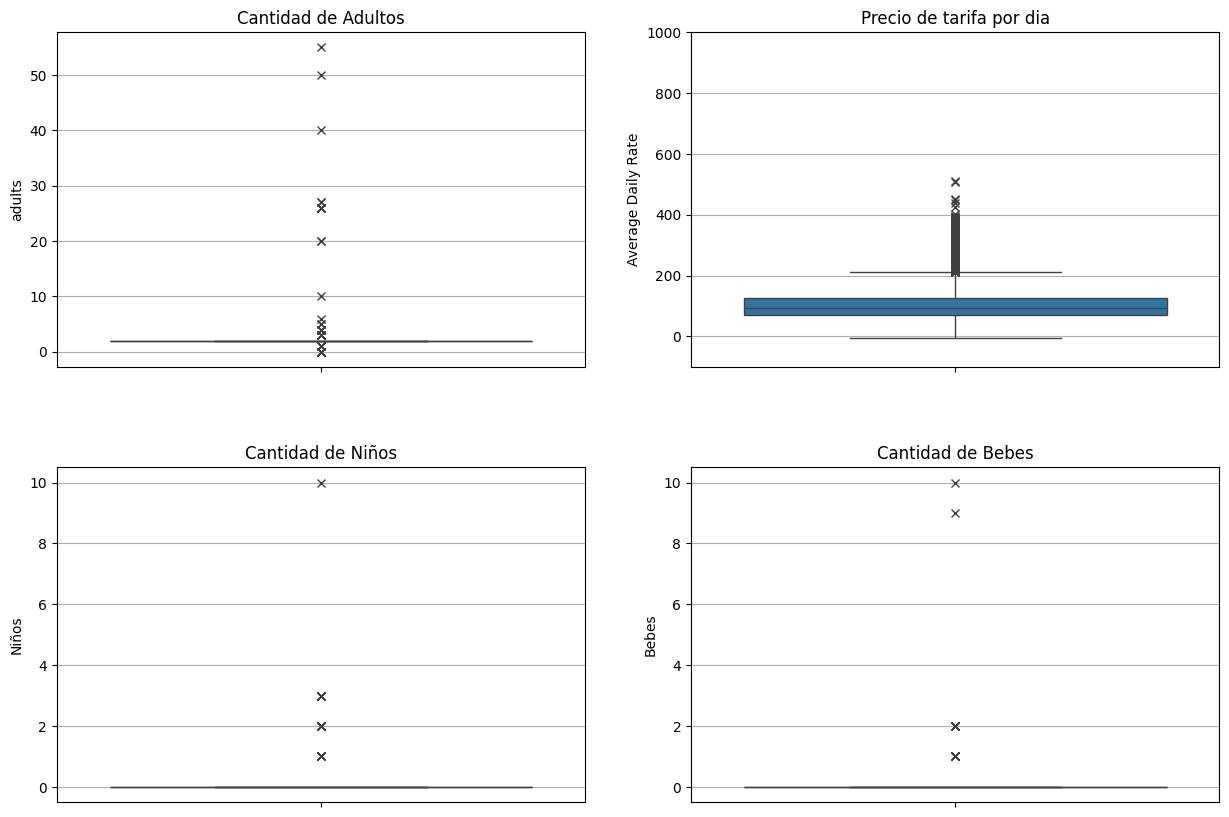

In [23]:
fig,ax = plt.subplots(2,2, figsize= (15,10))
plt.subplots_adjust(hspace=.3) #Aumentamos el espacio en cada plot

#PLOT 1
ax[0,0].grid()
ax[0,0].set(title="Cantidad de Adultos")
sns.boxplot(data=booking_copy, flierprops={"marker": "x"},y="adults", ax=ax[0,0])


#PLOT 2
ax[0,1].grid()
ax[0,1].set(title="Precio de tarifa por dia", ylabel= "Average Daily Rate")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="adr",ax=ax[0,1]).set(ylim=(-100,1000))

#PLOT 3
ax[1,0].grid()
ax[1,0].set(title="Cantidad de Niños", ylabel= "Niños")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="children", ax=ax[1,0])

#PLOT 4
ax[1,1].grid()
ax[1,1].set(title="Cantidad de Bebes", ylabel= "Bebes")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="babies", ax=ax[1,1])

plt.show()

- <p style="color:rgb(220,220,0)">Aclaracion:</p> El siguiente paso es realizado para ser más explicito, pero a simple viste se puede observar que no hay gran cantidad de outliers.

In [32]:
# Veremos que tantos registros ocupan de nuestro dataframe los outliers para ser eliminados

print(booking_copy[booking_copy["adults"] >= 20 ].shape[0])

print(booking_copy[(booking_copy["adr"] >= 400) | (booking_copy["adr"]<0)].shape[0])

print(booking_copy[booking_copy["children"] >= 4 ].shape[0])

print(booking_copy[booking_copy["babies"] >=4 ].shape[0])

12
9
1
2


- Utilizamos la funcion `query` para filtrar varias columnas a la vez.

In [35]:
booking_copy.query(expr="adults<20 & adr<400 & adr>0 & children <= 4 & babies <= 4", inplace=True)

### <u>Análisis y comportamiento de las reservas canceladas</u>

In [36]:
approved, canceled = booking_copy[booking_copy["is_canceled"]==0], booking_copy[booking_copy["is_canceled"]==1]